In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pd.set_option('max_rows', 100)

In [3]:
df = pd.read_csv('../../data/stability_paper_data/Perovskite_Stability_with_features.csv')

In [4]:
df.std(axis=0).sort_values().head(11)

Bsite_IsMetal_max                0.000000
Asite_GSmagmom_min               0.000000
Asite_IsHalogen_weighted_avg     0.000000
host_Asite0_IsCubic              0.000000
Asite_IsBoron_weighted_avg       0.000000
host_Asite0_NsValence            0.000000
host_Bsite0_IsNoblegas           0.000000
host_Asite0_IsAlkali             0.000000
Bsite_IsMetal_weighted_avg       0.023298
Asite_IsPnictide_weighted_avg    0.029083
Asite_BCCenergydiff_min          0.058821
dtype: float64

In [5]:
DESCRIPTOR_COLUMNS = [
    'Material Composition', 
    'A site #1', 
    'A site #2', 
    'A site #3',
    'B site #1', 
    'B site #2', 
    'B site #3', 
    'X site',
]

# those with 0 std dev
DROP_COLUMNS = [
    'Bsite_IsMetal_max',
    'Asite_GSmagmom_min',
    'Asite_IsHalogen_weighted_avg',
    'host_Asite0_IsCubic',
    'Asite_IsBoron_weighted_avg',
    'host_Asite0_NsValence',
    'host_Bsite0_IsNoblegas',
    'host_Asite0_IsAlkali',
]

TARGET_VARIABLE = 'energy_above_hull (meV/atom)'

CATEGORICAL_VARIABLE_COLUMNS = [
    'Number of elements',
    'num_of_atoms_host_Asite0',
    'host_Asite0_IsBCC',
    'host_Asite0_OrbitalD',
    'host_Bsite0_IsHexagonal',
    'Asite_IsAlkali_max',
]

In [6]:
sub_df = df.drop(DESCRIPTOR_COLUMNS + DROP_COLUMNS, axis=1).copy()

In [7]:
sub_df.shape

(1929, 65)

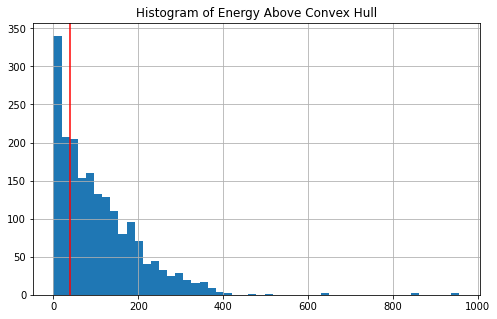

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

sub_df[TARGET_VARIABLE].hist(bins=50, ax=ax)
ax.set_title('Histogram of Energy Above Convex Hull')
ax.axvline(x=40, c='red')  # 40meV/atom is the line authors distinguish stable vs. unstable for classification
plt.show()

In [9]:
numerical_cols = sub_df.columns.difference(CATEGORICAL_VARIABLE_COLUMNS)
categorical_cols = CATEGORICAL_VARIABLE_COLUMNS

In [10]:
corr_table = sub_df[numerical_cols].corr()[TARGET_VARIABLE].drop(TARGET_VARIABLE, axis=0).sort_values()

In [11]:
corr_table = corr_table.to_frame('corr')
corr_table['abs_corr'] = corr_table['corr'].abs()
corr_table = corr_table.sort_values('abs_corr', ascending=False)

- Comment: Should be careful whether we include formation energy as a predictor or not.
    According to README, "A second property to predict is included in the 'formation_energy (eV/atom)' column.
    The formation energy given is the DFT energy of the perovskite structure relative to the
    DFT energy of the appropriate concentrations of elemental end-members in their stable state." So it seems that this column is result of DFT calculation, and not suitable to use as an independent variable.

In [12]:
top_corrs = corr_table.head(10)
top_corrs

,corr,abs_corr
formation_energy (eV/atom),0.692898,0.692898
Asite_BCCenergy_pa_max,0.475000,0.475000
GSenergy_pa_AB_avg,0.473988,0.473988
Asite_BCCenergydiff_min,-0.472071,0.472071
thermal conductivity_AB_avg,0.445189,0.445189
Asite_BCCefflatcnt_range,0.424259,0.424259
Asite_Atomic Volume (cm³/mol)_max,0.414063,0.414063
Asite_Atomic Radius (Å)_max,0.409994,0.409994
Asite_shannon_radii_range,0.400646,0.400646
specific heat capacity_AB_diff,0.395887,0.395887


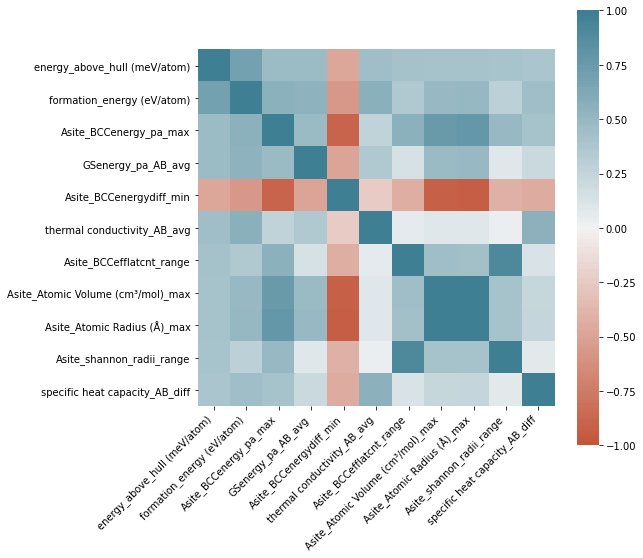

In [13]:
# just making it look nice

corr_to_plot = sub_df[[TARGET_VARIABLE] + list(top_corrs.index.values)].corr()

fig, ax = plt.subplots(figsize=(8, 8))

ax = sns.heatmap(
    corr_to_plot, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

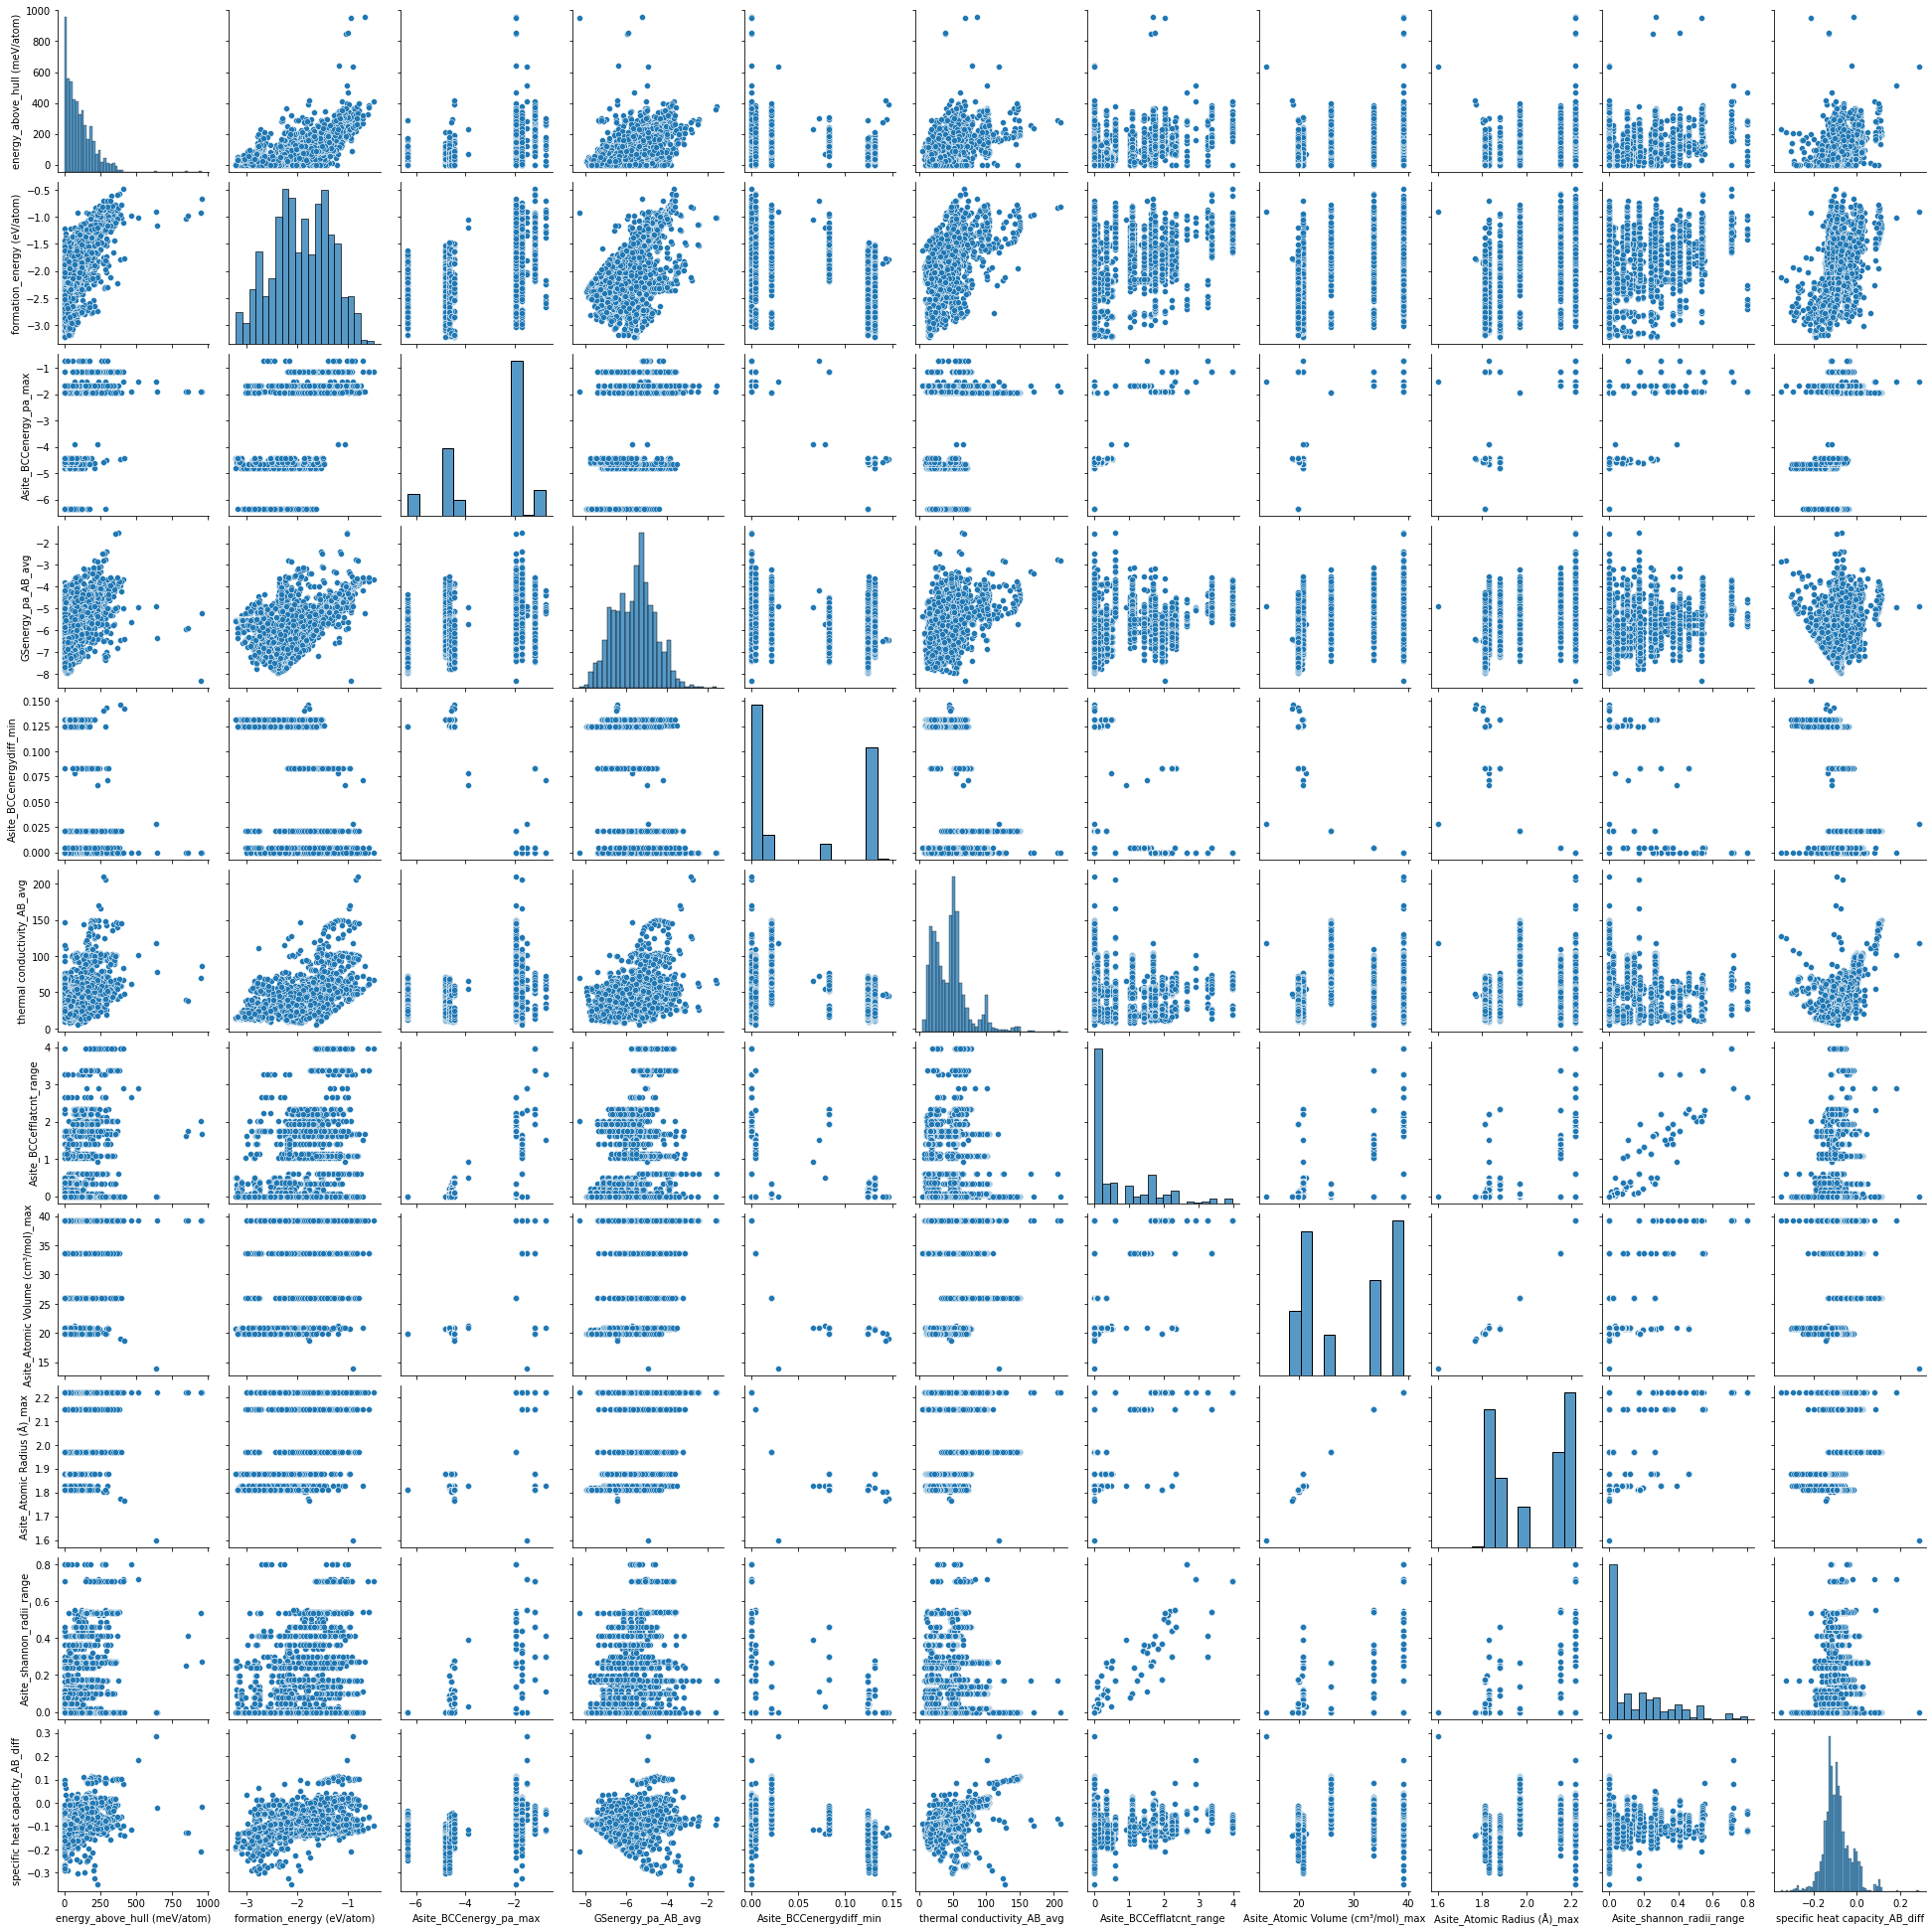

In [14]:
sns.pairplot(sub_df[[TARGET_VARIABLE] + list(top_corrs.index.values)])

- Comment: The A/B min/max features look quite 'discrete' - probably due to the way in they constructed the features that multiple compounds get the same value for these

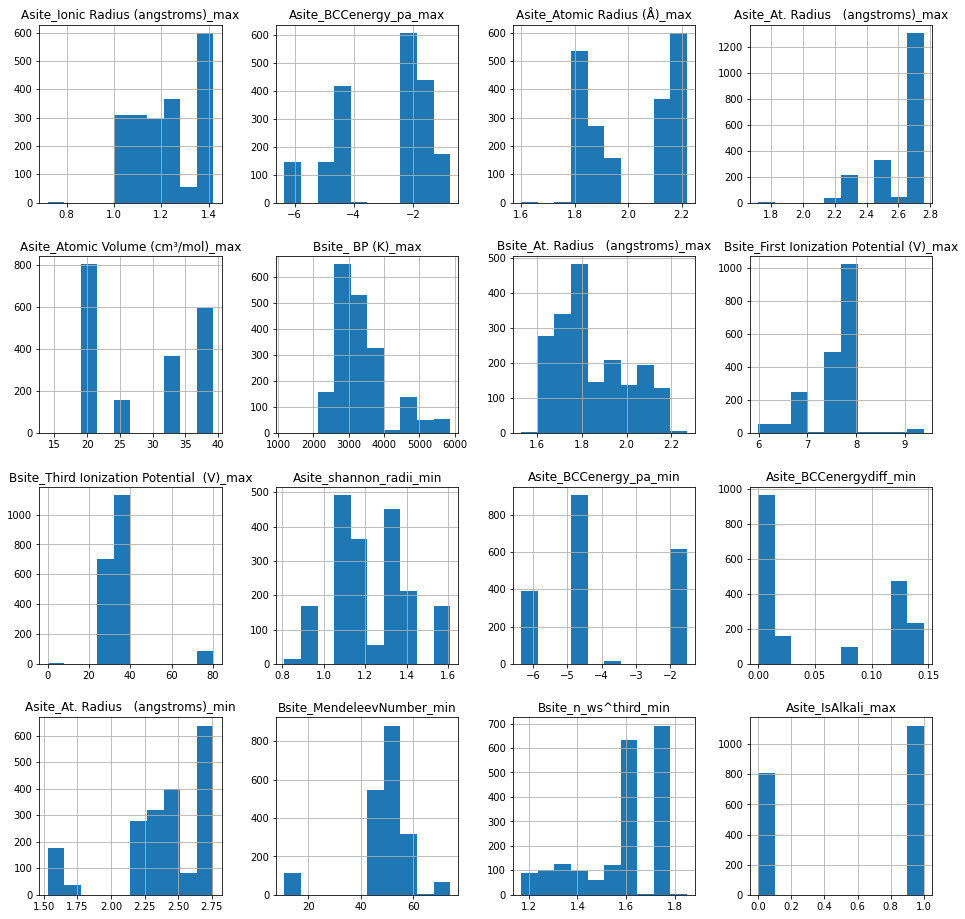

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

sub_df[sub_df.columns[sub_df.columns.str.endswith('_min') | sub_df.columns.str.endswith('_max')]].hist(ax=axes)
plt.show()

- Comment: In general, don't see too much visual separation. Maybe the one feature that seems to give more separation is 'Asite_IsAlkali_max' (when this feature = 1, it tends to have higher energy above convex hull)

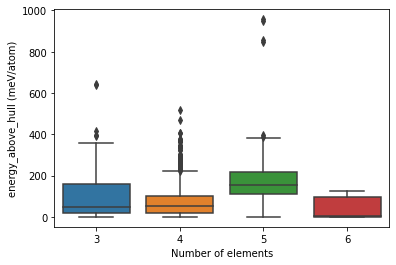

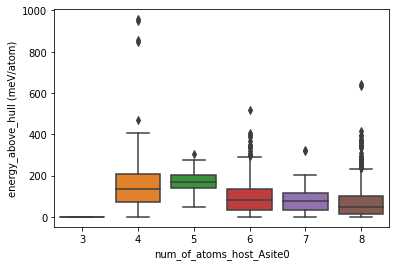

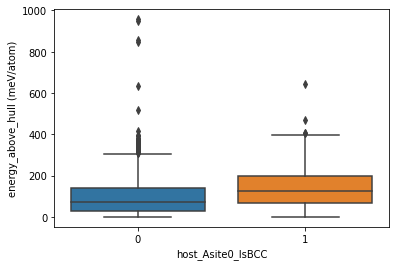

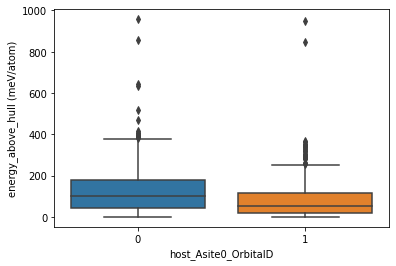

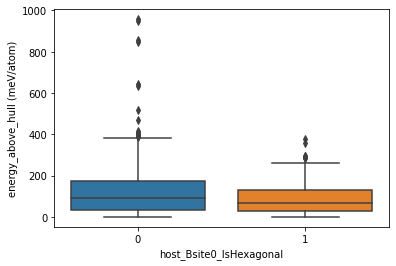

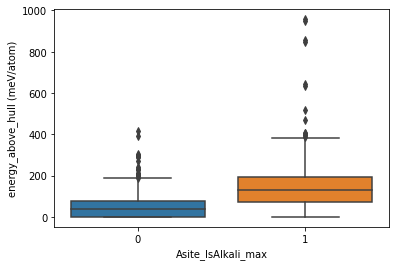

In [16]:
for cat_var in CATEGORICAL_VARIABLE_COLUMNS:

    plt.figure()
    sns.boxplot(data=sub_df[[cat_var, TARGET_VARIABLE]], x=cat_var, y=TARGET_VARIABLE)

plt.show()

The purpose of below is not for careful modeling but more for understanding feature importance

In [17]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [18]:
classif_df = sub_df.copy()
classif_df['y'] = (sub_df[TARGET_VARIABLE] >= 40).astype(int)
classif_df = classif_df.drop(TARGET_VARIABLE, axis=1)

In [19]:
classif_df['y'].value_counts()

1    1362
0     567
Name: y, dtype: int64

In [20]:
X = classif_df.drop('y', axis=1)
y = classif_df['y']

In [21]:
params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 2, 4],
}

In [22]:
# maybe should use stratified to consider the imbalance, but using just gridsearch for ease for now

gs = GridSearchCV(RandomForestClassifier(),
                  params,
                  cv=5,
                  n_jobs=-1)

In [23]:
gs.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [50, 100, 150]})

In [24]:
pd.DataFrame({
    'feature': X.columns,
    'importance': gs.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).head(10)

,feature,importance
1,formation_energy (eV/atom),0.097866
54,Bsite_At. #_weighted_avg,0.038971
10,GSenergy_pa_AB_avg,0.037043
30,Bsite_At. Radius (angstroms)_weighted_avg,0.032863
16,MendeleevNumber_AB_avg,0.031601
24,Heat of Vaporization_AB_ratio,0.031298
34,Asite_BCCenergy_pa_max,0.031287
31,Bsite_Second Ionization Potential (V)_weighte...,0.029423
22,BCCefflatcnt_AB_ratio,0.025381
12,covalent radius_AB_avg,0.024142
